# Dependency

In [1]:
import h5py
import os
import pickle

from tqdm import tqdm
from time import gmtime, strftime
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN
from imblearn.over_sampling import RandomOverSampler

import numpy as np
import math

from sklearn.decomposition import IncrementalPCA
from sklearn.decomposition import PCA
from sklearn import metrics
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve



import tensorflow as tf
from tensorflow.keras import layers,Model

##

from sklearn.model_selection import KFold

import gc

import time
from sklearn.model_selection import KFold

#import import_test_ETC as load_data
import import_test as load_data
#import import_test_nine as load_data

2024-07-23 08:30:22.563054: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-23 08:30:22.587010: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-23 08:30:22.922102: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# PARAM

In [2]:
DATA_LABEL=load_data.data_label()


WINDOW=5
MAXSEQ = WINDOW*2+1
DATA_TYPE = "esm2"
#"/BinaryMatrix" "/MMseqs2" "/"
#"/tape" "/ProtTrans" "/esm" 


#"20" "20" "1024" "768" "1280"
NUM_FEATURE = 1280

NUM_FILTER = 1024
NUM_HIDDEN = 1000#100
BATCH_SIZE  = 1024
WINDOW_SIZES = [2,4,6,8,10]


NUM_CLASSES = 2
CLASS_NAMES = ['Negative','Positive']


EPOCHS      = 20

K_Fold = 5
VALIDATION_MODE="cross"
#"independent" "cross""LOAD"
IMBALANCE="None"
#None
#SMOTE
#ADASYN
#RANDOM



#IMBLANCE="RANDOM"#"ADASYN" "RANDOM" "None" "SMOTE"
#SHUFFLE="Non-SHUFFLE"#Non-SHUFFLE

In [3]:
import datetime

write_data=[]
a=datetime.datetime.now()
write_data.append(time.ctime())
write_data.append(DATA_LABEL)
write_data.append(DATA_TYPE)
write_data.append(BATCH_SIZE)
write_data.append(NUM_HIDDEN)
write_data.append(WINDOW_SIZES)
write_data.append(NUM_FILTER)
write_data.append(VALIDATION_MODE)
write_data.append(IMBALANCE)

#write_data.append(IMBLANCE)
#write_data.append(SHUFFLE)

# Time_log

In [4]:
def time_log(message):
    print(message," : ",strftime("%Y-%m-%d %H:%M:%S", gmtime()))

In [5]:

import time
import math
def SAVEROC(fpr,tpr,ROCAUC,precisions, recalls,PRAUC):
    data_to_save = {
        "fpr": fpr,
        "tpr": tpr,
        "ROCAUC": ROCAUC,
        "precisions":precisions, 
        "recalls":recalls,
        "PRAUC":PRAUC
        
    }
    
    with open("./PKL/MCNN_"+DATA_TYPE+"_"+str(math.floor(time.time()))+".pkl", "wb") as file:
        pickle.dump(data_to_save, file)

# MCNN

In [6]:
class DeepScan(Model):

	def __init__(self,
	             input_shape=(1, MAXSEQ, NUM_FEATURE),
	             window_sizes=[32],
	             num_filters=256,
	             num_hidden=1000):
		super(DeepScan, self).__init__()
		# Add input layer
		self.input_layer = tf.keras.Input(input_shape)
		self.window_sizes = window_sizes
		self.conv2d = []
		self.maxpool = []
		self.flatten = []
		for window_size in self.window_sizes:
			self.conv2d.append(
                layers.Conv2D(filters=num_filters,
    			              kernel_size=(1, window_size),
			                  activation=tf.nn.relu,
			                  padding='valid',
			                  bias_initializer=tf.constant_initializer(0.1),
			                  kernel_initializer=tf.keras.initializers.GlorotUniform()
                             )
                             )
			self.maxpool.append(
    			layers.MaxPooling2D(pool_size=(1, MAXSEQ - window_size + 1),
			                        strides=(1, MAXSEQ),
			                        padding='valid')
                               )
			self.flatten.append(layers.Flatten())
		self.dropout = layers.Dropout(rate=0.7)
		self.fc1 = layers.Dense(num_hidden,
                        		activation=tf.nn.relu,
		                        bias_initializer=tf.constant_initializer(0.1),
		                        kernel_initializer=tf.keras.initializers.GlorotUniform()
                               )
		self.fc2 = layers.Dense(NUM_CLASSES,
		                        activation='softmax',
		                        kernel_regularizer=tf.keras.regularizers.l2(1e-3)
                               )

		# Get output layer with `call` method
		self.out = self.call(self.input_layer)

	def call(self, x, training=False):
		_x = []
		for i in range(len(self.window_sizes)):
			x_conv = self.conv2d[i](x)
			x_maxp = self.maxpool[i](x_conv)
			x_flat = self.flatten[i](x_maxp)
			_x.append(x_flat)

		x = tf.concat(_x, 1)
		x = self.dropout(x, training=training)
		x = self.fc1(x)
		x = self.fc2(x)  #Best Threshold
		return x

# Main

In [7]:
# Example usage:
#x_train,y_train,x_test,y_test= load_data.MCNN_data_load(MAXSEQ)
x_train,y_train,x_test,y_test= load_data.MCNN_data_load(DATA_TYPE)

In [8]:
import numpy as np

# 假設 [1, 0] 表示 'pos' 類別
pos_label_train_count = np.sum(y_train[:, 0] == 1)
pos_label_test_count = np.sum(y_test[:, 0] == 1)

print(f"Number of 'pos' labels in training data: {pos_label_train_count}")
print(f"Number of 'pos' labels in test data: {pos_label_test_count}")


Number of 'pos' labels in training data: 298503
Number of 'pos' labels in test data: 9911


In [9]:
print(x_train.shape)
print(x_train.dtype)
print(y_train.shape)
print()
print(x_test.shape)
print(x_test.dtype)
print(y_test.shape)

(314139, 1, 11, 1280)
float64
(314139, 2)

(10876, 1, 11, 1280)
float64
(10876, 2)


In [10]:
def model_test(model, x_test, y_test):

    #print(x_test.shape)
    pred_test = model.predict(x_test)
    #print(pred_test)
    #print(x_test)
    fpr, tpr, thresholds = roc_curve(y_test[:,1], pred_test[:, 1])
    ROCAUC = metrics.auc(fpr, tpr)
    #tf.test.is_gpu_available(cuda_only=False, min_cuda_compute_capability=None)

    precisions, recalls, thresholdss = precision_recall_curve(y_test[:,1], pred_test[:, 1])
    PRAUC = metrics.auc(recalls, precisions)
    
    
    display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=ROCAUC, estimator_name='mCNN')
    display.plot()

    disp2 =metrics.PrecisionRecallDisplay(precision= precisions, recall=recalls,average_precision=PRAUC,estimator_name='mCNN')
    disp2.plot()
    # calculate the g-mean for each threshold
    gmeans = np.sqrt(tpr * (1-fpr))
    # locate the index of the largest g-mean
    ix = np.argmax(gmeans)
    print(f'Best Threshold={thresholds[ix]}, G-Mean={gmeans[ix]}')
    threshold = thresholds[ix]

    y_pred = (pred_test[:, 1] >= threshold).astype(int)
    #print(y_pred)

    TN, FP, FN, TP =  metrics.confusion_matrix(y_test[0:][:,1], y_pred).ravel()

    Sens = TP/(TP+FN) if TP+FN > 0 else 0.0
    Spec = TN/(FP+TN) if FP+TN > 0 else 0.0
    Acc = (TP+TN)/(TP+FP+TN+FN)
    MCC = (TP*TN-FP*FN)/math.sqrt((TP+FP)*(TP+FN)*(TN+FP)*(TN+FN)) if TP+FP > 0 and FP+TN > 0 and TP+FN and TN+FN else 0.0
    F1 = 2*TP/(2*TP+FP+FN)
    Prec=TP/(TP+FP)
    Recall=TP/(TP+FN)
    print(f'TP={TP}, FP={FP}, TN={TN}, FN={FN}, Sens={Sens:.4f}, Spec={Spec:.4f}, Acc={Acc:.4f}, MCC={MCC:.4f}, ROCAUC={ROCAUC:.4f}, F1={F1:.4f}, Prec={Prec:.4f}, Recall={Recall:.4f}, PRAUC={PRAUC:.4f}\n')
    #SAVEROC(fpr,tpr,ROCAUC,precisions, recalls,PRAUC)
    return TP,FP,TN,FN,Sens,Spec,Acc,MCC,ROCAUC,F1,Prec,Recall,PRAUC

Start cross  :  2024-07-23 00:30:28
1 / 5 

(251311, 1, 11, 1280)
(62828, 1, 11, 1280)
(251311, 2)
(62828, 2)
Model: "deep_scan"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 1, 10, 1024)       2622464   
                                                                 
 conv2d_1 (Conv2D)           (None, 1, 8, 1024)        5243904   
                                                                 
 conv2d_2 (Conv2D)           (None, 1, 6, 1024)        7865344   
                                                                 
 conv2d_3 (Conv2D)           (None, 1, 4, 1024)        10486784  
                                                                 
 conv2d_4 (Conv2D)           (None, 1, 2, 1024)        13108224  
                                                                 
 max_pooling2d (MaxPooling2D  (None, 1, 1, 1024)       0         
 )           

2024-07-23 08:30:33.697792: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-23 08:30:33.732498: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-23 08:30:33.732633: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Epoch 1/20


2024-07-23 08:30:49.012437: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8903
2024-07-23 08:30:50.735976: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-07-23 08:30:50.745988: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x20678eb0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-07-23 08:30:50.745999: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA GeForce RTX 3090 Ti, Compute Capability 8.6
2024-07-23 08:30:50.756779: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-07-23 08:30:50.862994: I ./tensorflow/compiler/jit/device_compiler.h:180] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the pr

7854/7854 [==============================] - 95s 11ms/step - loss: 0.1287 - accuracy: 0.9533
Epoch 2/20
7854/7854 [==============================] - 89s 11ms/step - loss: 0.1082 - accuracy: 0.9574
Epoch 3/20
7854/7854 [==============================] - 89s 11ms/step - loss: 0.0967 - accuracy: 0.9610
Epoch 4/20
7854/7854 [==============================] - 90s 11ms/step - loss: 0.0861 - accuracy: 0.9646
Epoch 5/20
7854/7854 [==============================] - 89s 11ms/step - loss: 0.0779 - accuracy: 0.9675
Epoch 6/20
7854/7854 [==============================] - 89s 11ms/step - loss: 0.0711 - accuracy: 0.9705
Epoch 7/20
7854/7854 [==============================] - 89s 11ms/step - loss: 0.0671 - accuracy: 0.9725
Epoch 8/20
7854/7854 [==============================] - 89s 11ms/step - loss: 0.0637 - accuracy: 0.9741
Epoch 9/20
7854/7854 [==============================] - 89s 11ms/step - loss: 0.0610 - accuracy: 0.9756
Epoch 10/20
7854/7854 [==============================] - 89s 11ms/step - lo

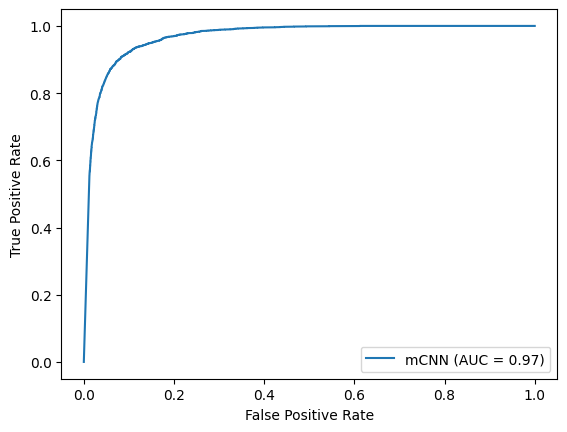

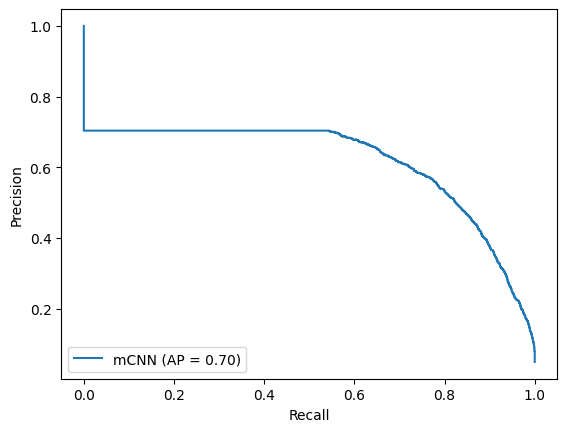

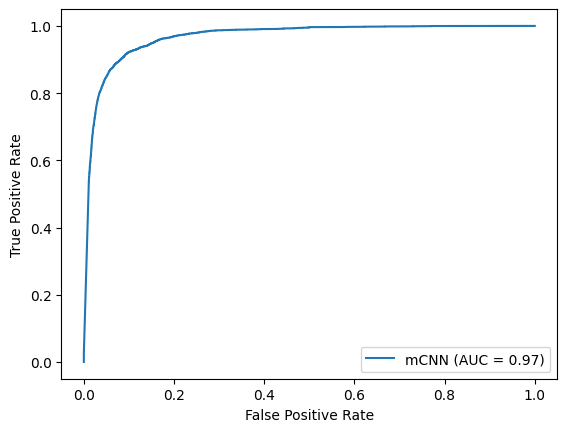

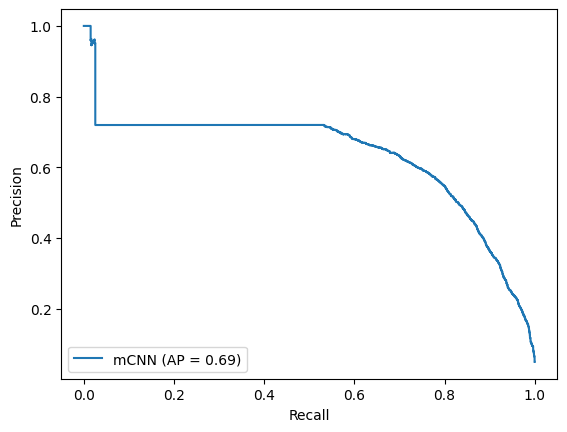

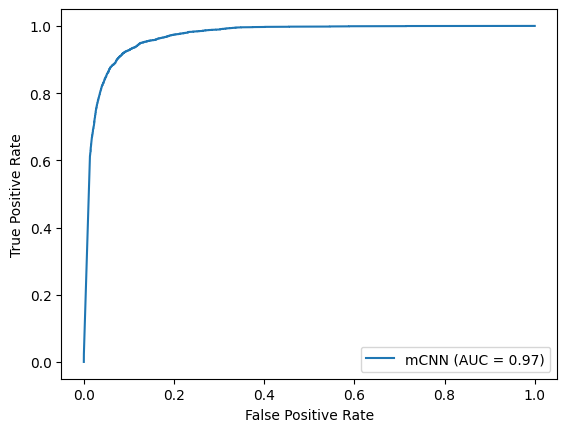

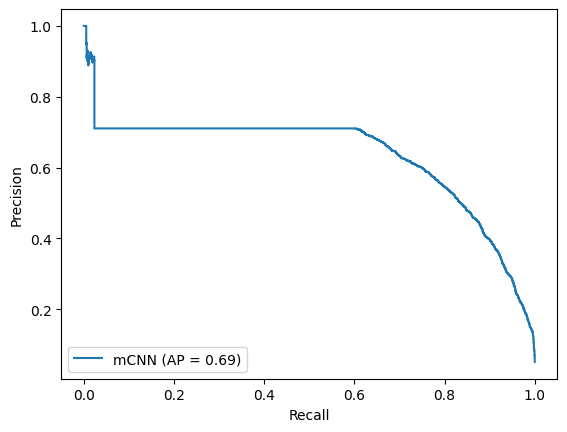

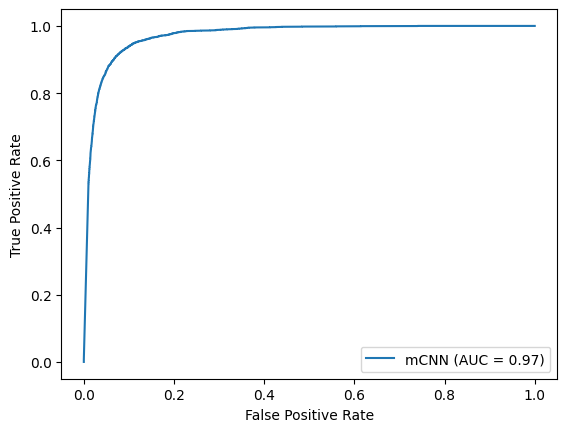

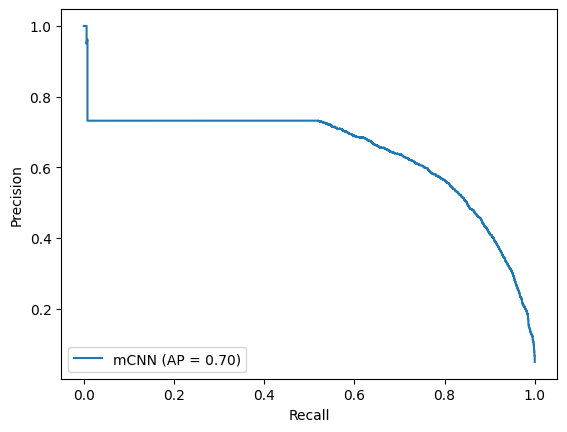

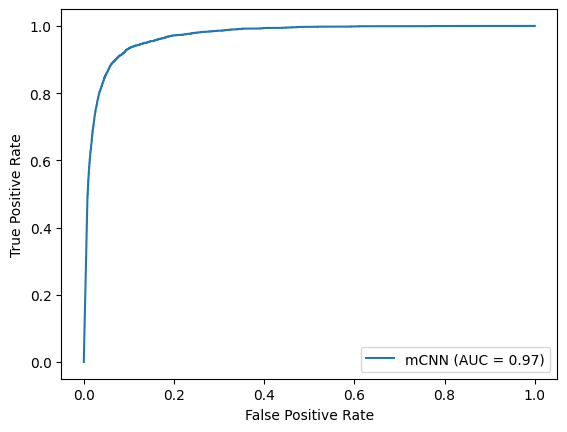

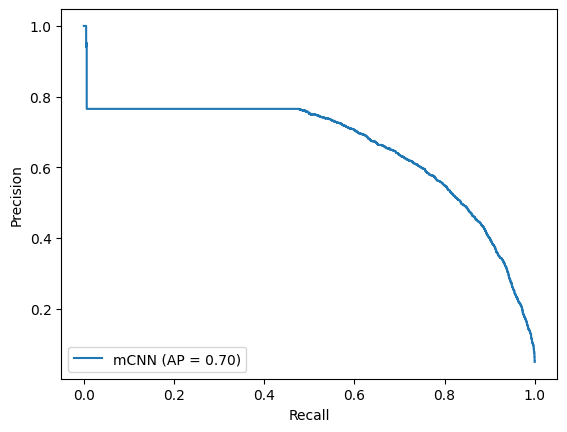

In [11]:
if(VALIDATION_MODE=="cross"):
	time_log("Start cross")
	
	kfold = KFold(n_splits = K_Fold, shuffle = True, random_state = 2)
	results=[]
	i=1
	for train_index, test_index in kfold.split(x_train):
		print(i,"/",K_Fold,'\n')
		# 取得訓練和測試數據
		X_train, X_test = x_train[train_index], x_train[test_index]
		Y_train, Y_test = y_train[train_index], y_train[test_index]
		
		print(X_train.shape)
		print(X_test.shape)
		print(Y_train.shape)
		print(Y_test.shape)
		# 重新建模
		model = DeepScan(
		num_filters=NUM_FILTER,
			num_hidden=NUM_HIDDEN,
			window_sizes=WINDOW_SIZES)
		model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
		model.build(input_shape=X_train.shape)
		model.summary()
		# 在測試數據上評估模型
		history=model.fit(
			X_train,
    		Y_train,
			epochs=EPOCHS,
			callbacks=[tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10)],
			verbose=1,
			shuffle=True
		)
		TP,FP,TN,FN,Sens,Spec,Acc,MCC,ROCAUC,F1,Prec,Recall,PRAUC = model_test(model, X_test, Y_test)
		results.append([TP,FP,TN,FN,Sens,Spec,Acc,MCC,ROCAUC,F1,Prec,Recall,PRAUC])
		i+=1
		
		del X_train
		del X_test
		del Y_train
		del Y_test
		gc.collect()
		
	mean_results = np.mean(results, axis=0)
	print(f'TP={mean_results[0]:.4}, FP={mean_results[1]:.4}, TN={mean_results[2]:.4}, FN={mean_results[3]:.4}, Sens={mean_results[4]:.4}, Spec={mean_results[5]:.4}, Acc={mean_results[6]:.4},MCC={mean_results[7]:.4},ROCAUC={mean_results[8]:.4},F1={mean_results[9]:.4},Prec={mean_results[10]:.4},Recall={mean_results[11]:.4},PRAUC={mean_results[12]:.4}\n')
    
	write_data.append(mean_results[0])
	write_data.append(mean_results[1])
	write_data.append(mean_results[2])
	write_data.append(mean_results[3])
	write_data.append(mean_results[4])
	write_data.append(mean_results[5])
	write_data.append(mean_results[6])
	write_data.append(mean_results[7])
	write_data.append(mean_results[8])
	write_data.append(mean_results[9])
	write_data.append(mean_results[10])
	write_data.append(mean_results[11])
	write_data.append(mean_results[12])



In [12]:
VALIDATION_MODE="independent"

In [13]:
if(VALIDATION_MODE=="independent"):
    
    time_log("Start Model Train")
    model = DeepScan(
    	num_filters=NUM_FILTER,
    	num_hidden=NUM_HIDDEN,
    	window_sizes=WINDOW_SIZES)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    model.build(input_shape=x_train.shape)
    model.summary()
    model.fit(
    	x_train,
		y_train,
    	epochs=EPOCHS,
    	shuffle=True,
    )
    time_log("End Model Train")
    time_log("Start Model Test")
    TP,FP,TN,FN,Sens,Spec,Acc,MCC,ROCAUC,F1,Prec,Recall,PRAUC = model_test(model, x_test, y_test)
    write_data.append(TP)
    write_data.append(FP)
    write_data.append(TN)
    write_data.append(FN)
    write_data.append(Sens)
    write_data.append(Spec)
    write_data.append(Acc)
    write_data.append(MCC)
    write_data.append(ROCAUC)
    write_data.append(F1)
    write_data.append(Prec)
    write_data.append(Recall)
    write_data.append(PRAUC)
    
    time_log("End Model Test")

Start Model Train  :  2024-07-23 03:01:11
Model: "deep_scan_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_25 (Conv2D)          (None, 1, 10, 1024)       2622464   
                                                                 
 conv2d_26 (Conv2D)          (None, 1, 8, 1024)        5243904   
                                                                 
 conv2d_27 (Conv2D)          (None, 1, 6, 1024)        7865344   
                                                                 
 conv2d_28 (Conv2D)          (None, 1, 4, 1024)        10486784  
                                                                 
 conv2d_29 (Conv2D)          (None, 1, 2, 1024)        13108224  
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 1, 1, 1024)       0         
 g2D)                                                            
             

2024-07-23 11:01:28.891619: W tensorflow/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 16.48GiB (rounded to 17692308480)requested by op _EagerConst
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2024-07-23 11:01:28.891646: I tensorflow/tsl/framework/bfc_allocator.cc:1039] BFCAllocator dump for GPU_0_bfc
2024-07-23 11:01:28.891651: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (256): 	Total Chunks: 46, Chunks in use: 45. 11.5KiB allocated for chunks. 11.2KiB in use in bin. 236B client-requested in use in bin.
2024-07-23 11:01:28.891653: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (512): 	Total Chunks: 0, Chunks in use: 0. 0B allocated for chunks. 0B in use in bin. 0B client-requested in use in bin.
2024-07-23 11:01:28.891656: I tensorflow/tsl/framework/bfc_allocato

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

In [ ]:
#model.save('model_ProtTrans', save_format='tf')

In [ ]:
def save_csv(write_data,a):
    import csv
    b=datetime.datetime.now()
    write_data.append(b-a)
    open_csv=open("./independent.csv","a")
    write_csv=csv.writer(open_csv)
    write_csv.writerow(write_data)
save_csv(write_data,a)